# uMAIA Overview

This tutorial will introduce you to the usage of uMAIA, a toolbox designed for the processing and analysis of MALDI-MSI data. 

The whole pipeline of uMAIA consists of 3 parts as the following figure suggests:


<div>
<center>
<img src="figs/MAIA workflow.png" width="800">
</center>
</div>

The uMAIA package consists of 3 main modules: <code>peak_finding (pf)</code>, <code>molecular_matcher (mm)</code> and <code>normalizer (norm)</code>. In addition to that there are two other modules to help with loading the data in different stages and visualization, namely <code>utils (ut)</code> and <code>visualize (vis)</code>.

In [1]:
import uMAIA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os

warnings.filterwarnings("ignore")

/home/schede/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# we will download the datasets - this may take a few minutes!
os.mkdir('rawData')

!wget https://zenodo.org/record/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um.IBD -P rawData
!wget https://zenodo.org/record/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um.imzml -P rawData
!wget https://zenodo.org/record/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section26_345x136_Att35_7um.IBD -P rawData
!wget https://zenodo.org/record/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section26_345x136_Att35_7um.imzml -P rawData
!wget https://zenodo.org/record/8410583/files/20220621_Zebrafish_atlas_72hpf_fish2_section24_422x135_Att35_7um.IBD -P rawData
!wget https://zenodo.org/record/8410583/files/20220621_Zebrafish_atlas_72hpf_fish2_section24_422x135_Att35_7um.imzml -P rawData
!wget https://zenodo.org/record/8410583/files/20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um.IBD -P rawData
!wget https://zenodo.org/record/8410583/files/20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um.imzml -P rawData
!wget https://zenodo.org/record/8410583/files/20220702_Zebrafish_atlas_72hpf_fish2_section_18_452x136_Att35_7um.IBD -P rawData
!wget https://zenodo.org/record/8410583/files/20220702_Zebrafish_atlas_72hpf_fish2_section_18_452x136_Att35_7um.imzml -P rawData



--2023-11-17 10:21:59--  https://zenodo.org/record/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um.IBD
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um.IBD [following]
--2023-11-17 10:21:59--  https://zenodo.org/records/8410583/files/20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um.IBD
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 882241348 (841M) [application/octet-stream]
Saving to: ‘rawData/20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um.IBD’

20220620_Zebrafish_ 100%[===================>] 841.37M  72.8MB/s    in 14s     

2023-11-17 10:22:13 (61.3 MB/s) - ‘rawData/20220620_Zebrafish_atlas_72hpf_f

## Step 1: Image Extraction using adaptive Peak Finder

***uMAIA*** identifies more molecules than other freely-available software, imaging them automatically with higher quality.

To load the raw data you need to specify the path to the **IBD** and **imzml** files, which contain the raw output of MALDI mass spectrometer and the correspoding metadata.

In [2]:
path_data = 'rawData'
path_save = 'data'
name = '20220620_Zebrafish_atlas_72hpf_fish2_section26_345x136_Att35_7um'

# create directories
uMAIA.ut.tools.createSaveDirectory(path_save)
uMAIA.ut.tools.createSaveDirectory(os.path.join(path_save, name))

smz = uMAIA.ut.SmzMLobj(f'{os.path.join(path_data,name)}.IBD',
                           f'{os.path.join(path_data,name)}.imzml',
                           mz_resolution=10e-5)

smz.load(load_unique_mz=True)
smz.S

Directory at data already exists


Loading Spectra at resolution 0.0001: 100%|██████████| 46920/46920 [00:01<00:00, 26608.80it/s]
Loading the m/z values at resolution 0.0001: 46920it [00:09, 5056.90it/s]
46920it [47:04, 16.61it/s]


<46920x3489327 sparse matrix of type '<class 'numpy.float64'>'
	with 61385980 stored elements in Compressed Sparse Column format>

You can visualize the raw frequencies of mass-to-charge ratios, and check that the suggested parameters function for your specific dataset. Datasets with poorer mz resolution will require a higher value for the `smoothing` parameter, or a larger value for `mz_resolution` if one is aware of the approximate resolution of the instrument. 

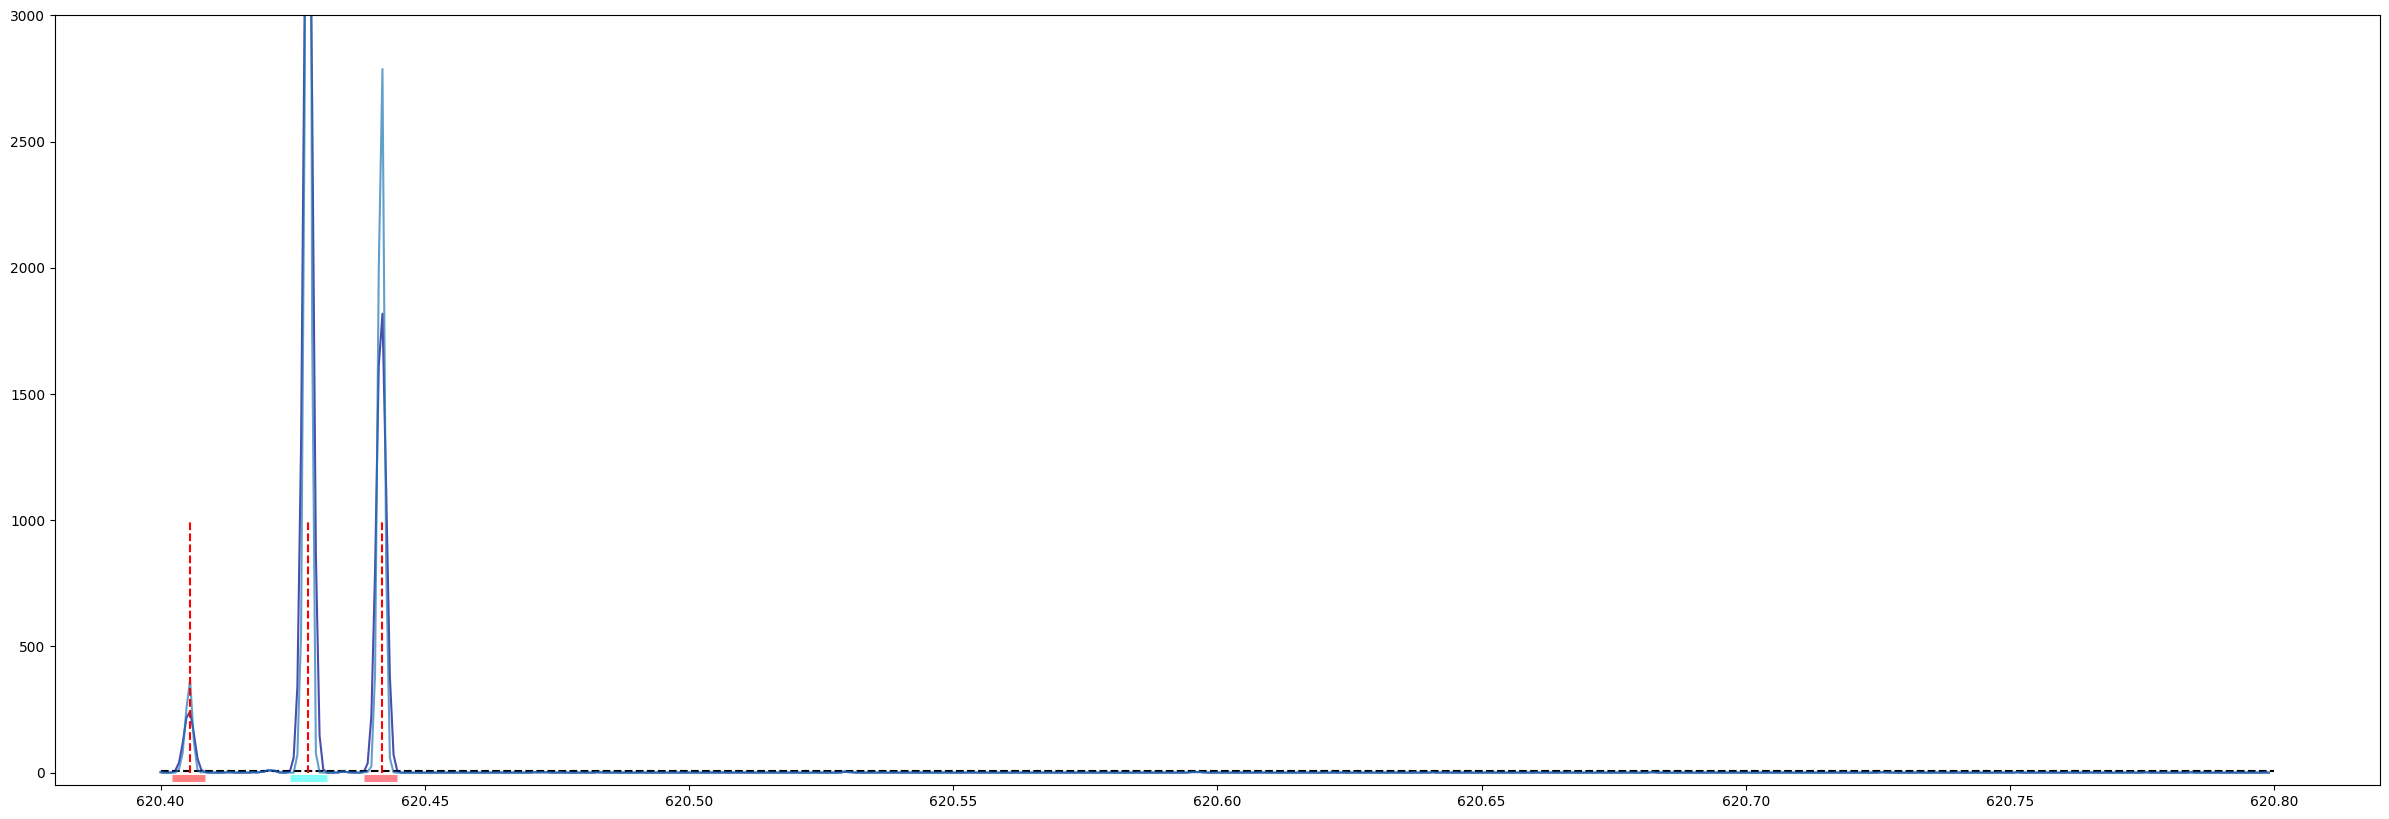

In [3]:
mz_resolution = 0.0001
threshold_count = 8.
approximate_interval =1.5
smoothing = 1. #2.5

mzrange_test = np.array([620.4,620.8])

PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=3000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

To identify the molecules you need to run the uMAIA peak finder with the specified parameters.

The output of the peak finder are the <code>images.h5ad</code> and <code>ranges.csv</code> files, which are then saved in the specified directory path.

In [4]:
uMAIA.pf.run(directory_path=os.path.join(path_save, name),
            smz=smz, 
            spectrum_range=(400,1200),
            threshold_count=threshold_count, 
            approximate_interval=approximate_interval,
            smoothing=smoothing,
            parallelize=True,
            saveimages=True)

Partioning m/z space and beginning peakcalling...


100%|██████████| 107/107 [09:44<00:00,  5.46s/it]


Creating dataframe...


100%|██████████| 29103/29103 [02:23<00:00, 203.05it/s]


DataFrame created successfully
Removing temporary storage
Saving images...


100%|██████████| 29103/29103 [03:07<00:00, 155.49it/s]


Complete


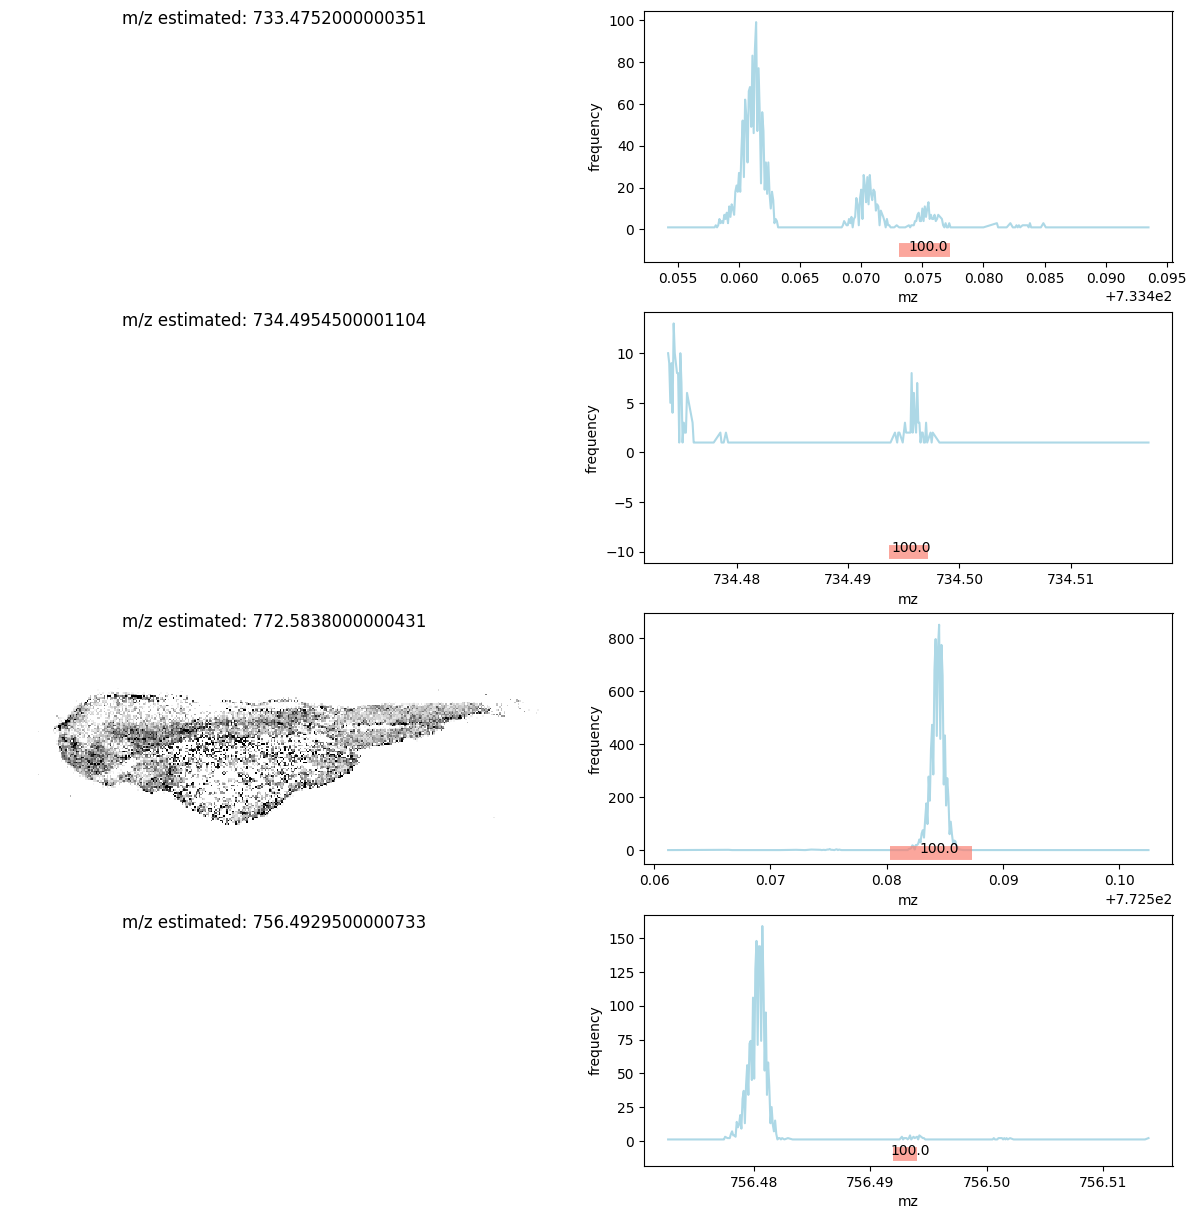

In [5]:
df_ranges = pd.read_csv(os.path.join(path_save, name, 'ranges.csv'), index_col=0)

adduct_H = 1.007
adduct_Na = 22.98977
adduct_K = 39.0983
adduct_NH4 = 14.0067 + 4 * adduct_H
s_mz =733.5


fig, mz_images = uMAIA.vis.image_mz(smz, df=df_ranges, 
                             mz_list=[s_mz, s_mz + adduct_H, s_mz + adduct_K, s_mz + adduct_Na], 
                             cmap='Greys',figsize=(15,15),
                             img_shape=smz.img_shape, limit=0.01,clip=99,
                            )

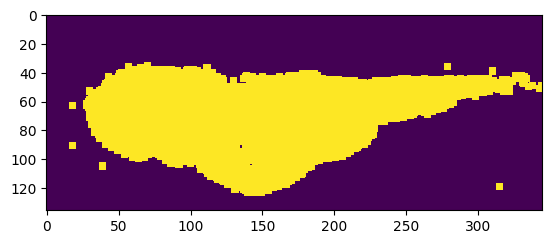

In [6]:
# save mask
import scipy
mask = mz_images[2]
mask = scipy.ndimage.gaussian_filter(mask, 0.5) > 0
plt.imshow(mask, interpolation='none')

In [7]:
np.save(f'data/{name}/mask.npy', mask)

## Step 2: Molecule Matching

***uMAIA*** retrieves identical molecules across acquistions without ambiguity.

In [4]:
acquisitions = [
    '20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um',
    # '20220702_Zebrafish_atlas_72hpf_fish2_section_18_452x136_Att35_7um', #done
    # '20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um', # done
    # '20220621_Zebrafish_atlas_72hpf_fish2_section24_422x135_Att35_7um', # done
    '20220620_Zebrafish_atlas_72hpf_fish2_section26_345x136_Att35_7um' # done
           ]

ranges_files = [os.path.join(path_save, name, 'ranges.csv') for name in acquisitions]
images_files = [os.path.join(path_save, name, 'images.h5ad') for name in acquisitions]


df_list = uMAIA.ut.tools.read_files(ranges_files) # load files
df_list = uMAIA.ut.tools.filterSparseImages(df_list, 3000) # filter sparse images (noise)

In [12]:
# df_match = uMAIA.mm.match(MAX_DIST=0.005, df_list=df_list)
# filter out molecules that we are not interested in imaging
df_filter = uMAIA.mm.filter_matches(df_match, num_match=2) 
df_filter.sort_values(['molecule_ID', 'section_ix'], inplace=True)

print(f'Number of unique molecules after filtering: {len(df_filter.molecule_ID.value_counts())}')

Number of unique molecules after filtering: 2755


In [13]:
# save the images to zarr format
PATH_SAVE = os.path.join(path_save, 'TestStack.zarr')
uMAIA.ut.tools.to_zarr(PATH_SAVE, acquisitions, df_filter, images_files)


100%|██████████| 2/2 [00:51<00:00, 25.75s/it]


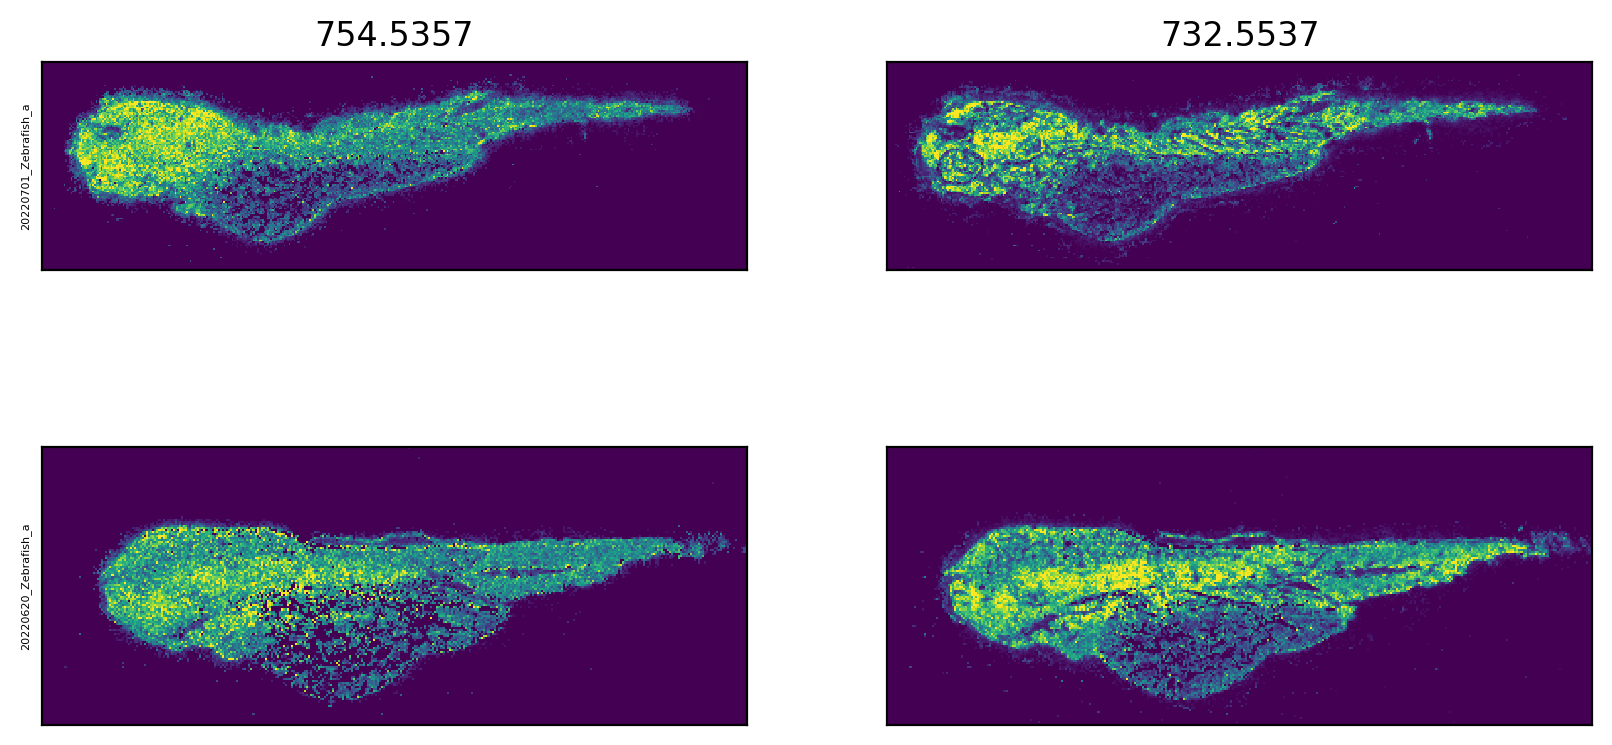

In [15]:
# visualize images
uMAIA.vis.showMatchedImages(PATH_SAVE, [754.5357,732.5538], acquisitions, figsize=(10,5))

## Step 3: Normalization

***uMAIA*** normalizes images by fitting a Bayesian model that accounts for different sources of noise in a regularized way and allows a conservative non-linear rescaling of intensity values such that qualifications can be properly compared across sections.

In [2]:
path_save = 'data'
PATH_SAVE = os.path.join(path_save, 'TestStack.zarr')

In [5]:
mask_list = [np.load(f'data/{m}/mask.npy') for m in acquisitions]

In [6]:
x, masks, masks_list = uMAIA.ut.tools.read_images_masks(acquisitions,
                                        path_images=PATH_SAVE, mask_list=mask_list,
                                        gaussian_smoothing=True, gaussian_sigma=0.4,
                                        log_transform=True, epsilon=0.0002
                                       )

Loading Data...: 2755it [00:08, 334.81it/s]

Data Loaded Successfully.


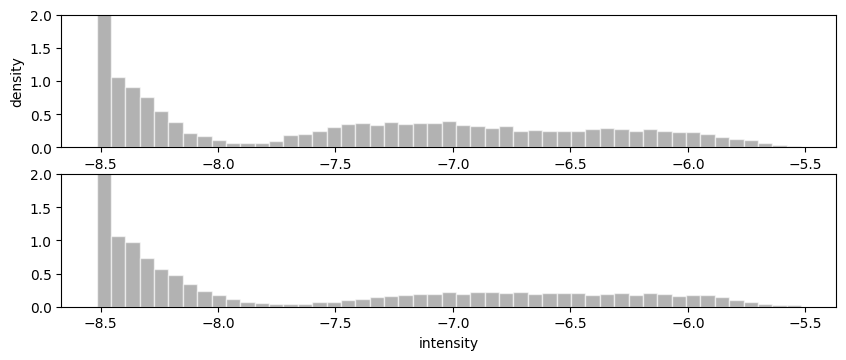

In [7]:
uMAIA.vis.plot_intensity(x, masks, v=50, mz_val=None)

We can model the MALDI-MSI data intensities’ histogram as a gaussian mixture model and approximate the true foreground distribution, where the non-biological batch effects have been taken into account. To normalize the data, uMAIA uses the following graphical model to address the batch effects.

<div>
<center>
<img src="figs/MAIA_PGM.png" width="800">
</center>
</div>

To initialize the SVI, we simply fit a GMM on the cumulative distribution of each molecule. We use BIC metric to choose whether a unimodal or bimodal gaussian distribution would fit the best on the intensities. It's also possible to intialize the required parameters manually and save them in a dictionary to pass for the normalization method.

In [8]:
init_state = uMAIA.norm.initialize(x, masks,  subsample=True)

GMM Initialization: 100%|██████████| 2755/2755 [00:35<00:00, 77.12it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
svi_result = uMAIA.norm.normalize(x, 
                              masks,
                              init_state=init_state,
                              subsample=True,
                              optimizer=None,
                              num_steps=5000,
                              seed=42)

FLEXMEAN:0.5
FLEXMEAN:0.5
FLEXMEAN:0.5
FLEXMEAN:0.5
FLEXMEAN:0.5


  0%|          | 0/5000 [00:00<?, ?it/s]

FLEXMEAN:0.5
FLEXMEAN:0.5
FLEXMEAN:0.5


100%|██████████| 5000/5000 [26:07<00:00,  3.19it/s, init loss: -4652107.0000, avg. loss [4751-5000]: -10776591.0000]


After normalization, you can save the parameters of interest using the utils module for further analysis.

In [10]:
PATH_SAVE = f'data/parameters_test'
try:
    os.mkdir(PATH_SAVE)
except:
    pass
uMAIA.ut.tools.save_svi(svi_result, PATH_SAVE)

Afterwards, you can transform your data to get the uMAIA normalized MALDI-MSI data and preform future downstream analysis.

In [11]:
x_tran = uMAIA.norm.transform(x, masks, svi_result)

You can visualize the raw intensities vs the normalized intensities and the fitted model in the same figure as well.

molecule susceptibility: 1.56


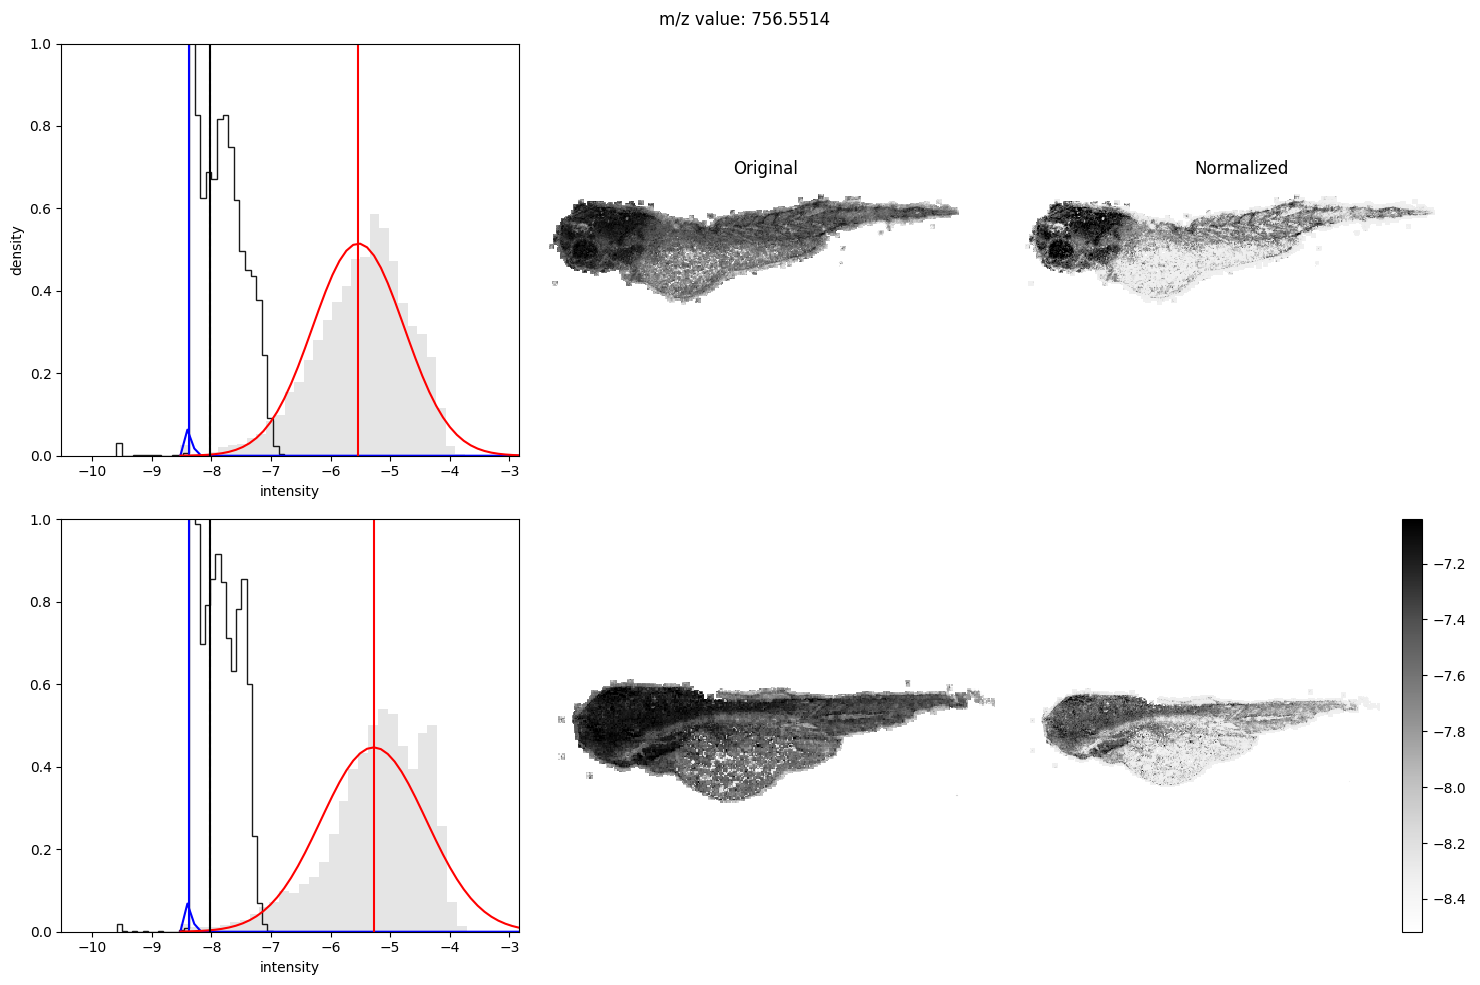

In [12]:
uMAIA.vis.normalized_hist(x_tran=x_tran, x=x, mask=masks, mask_2D_list=mask_list, svi_result=svi_result, zarr_path='data/TestStack.zarr', v_ind=None,mz_val=756.5514)

# example multivariate analysis

We begin by creating a matrix with pixels in rows and signals (metabolites) in columns 

In [18]:
import zarr
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.ndimage.morphology import binary_erosion
from sklearn.decomposition import PCA

# create a list of 2D masks
root = zarr.open('data/TestStack.zarr', mode='rb')
mz_list = np.array(list(root.group_keys()))

mask_2D = []#root[mz_list[v]][i_s][:]
for s in list(root[mz_list[0]].keys()):
    mask_2D.append(
        np.ones_like(root[mz_list[0]][s][:]).astype(bool)
    )
mask_2D_tissue = [np.load(f'data/{a}/mask.npy') for a in acquisitions]

In [19]:
# place the images into the format specified
all_images_resized_MAIA = []
for v in range(x_tran.shape[2]):

    images_processed = []
    for s in range(x_tran.shape[1]):
        image_raw  = uMAIA.vis.place_image(mask_2D, x_tran, v, s,np.log(0.0002))
        image = median_filter(image_raw, 2)
        image = gaussian_filter(image, 0.5) # 0.5
        
        # put values back to min value outside of image
        image[mask_2D_tissue[s].astype(bool) == False] = np.nan
        
        images_processed.append(image)
    images = np.concatenate([x.flatten() for x in images_processed])
    all_images_resized_MAIA.append(images)

all_images_resized_MAIA = np.array(all_images_resized_MAIA)
R_MAIA = np.array(all_images_resized_MAIA)[:,np.concatenate([m.flatten() for m in mask_2D_tissue]).astype(bool)].T


mask_index_cumsum = np.insert(np.cumsum([x.sum().astype(int) for x in mask_2D_tissue]),0,0)
batch_ix = np.zeros(R_MAIA.shape[0])#np.zeros_like(labels)
for i, b in enumerate(mask_index_cumsum[1:]):
    batch_ix[mask_index_cumsum[i] : b] = i

We want to look into structure brought about by lipids. To do so we use only mz values which correpsond to known lipids before applying PCA

In [20]:
mz_lipids = [760.5851, 734.5694, 782.5670, 756.5514, 788.6164, 723.4935, 774.6007,
             697.4779, 784.5851, 746.5694, 786.6007, 522.3554, 577.5190, 703.5748,
             544.3373, 720.5538, 828.5514, 810.5983, 784.5827, 706.5381, 798.5408, 
             568.3397, 447.1261, 769.4779, 832.5851, 802.5357, 832.5827, 469.1857, 
             496.3397, 830.5670, 748.5851, 732.5538, 496.3397, 806.5694, 764.5225, 
             725.5568, 806.5670, 754.5357, 590.3217, 780.5514, 768.5514, 808.5827, 
             786.5044]

ix_select = []
for mz in mz_lipids:
    ix = np.argmin(np.abs(mz - mz_list.astype(float)))
    ix_select.append(ix)

# standardize the data
Ycnt = R_MAIA[:,ix_select]
Ycnt = Ycnt - Ycnt.mean(0)
Ystd = Ycnt / Ycnt.std(0)
Ystd = np.nan_to_num(Ystd)

R_pcs = PCA().fit_transform(Ystd)

now we can show the PCs by placing the pixels back into their respective sectoins

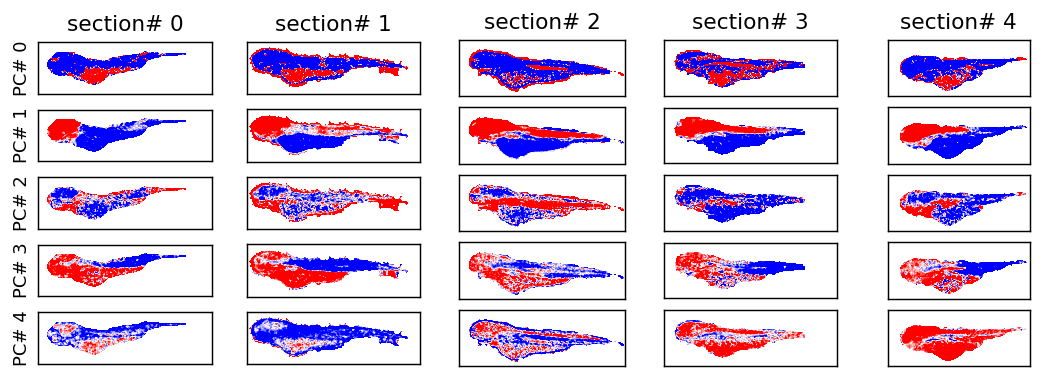

In [21]:
fig = plt.figure(None,(10,10), dpi=130)
gs = plt.GridSpec(15,x_tran.shape[1])
# take the PC


# mask_2D_tissue = []
for ip in range(5):
    R_pc = R_pcs[:,ip]
    for i_s, s in enumerate(np.unique(batch_ix).astype(int)):
        plt.subplot(gs[ip, i_s])

        if i_s == 0:
            plt.ylabel(f'PC# {ip}')

        if ip == 0:
            plt.title(f'section# {i_s}')
        # now find the indexes that belong to the section
        ix_s = batch_ix == s
        R_pc_s = R_pc[ix_s]
        vmin, vmax = np.percentile(R_pc_s, (5,95))
        vmax = np.max([np.abs(vmin), np.abs(vmax)])
        vmin = -vmax

        # put the image
        image = mask_2D_tissue[s].flatten().astype(bool)
        ix_ = np.argwhere(image).flatten()
        image = image.astype(float)
        image[:] = np.nan

        image[ix_] = R_pc_s
        image = image.reshape(mask_2D[s].shape)

        plt.imshow(image, cmap='bwr', vmin=-1, vmax=1)
        plt.yticks([])
        plt.xticks([])